## Task 12.1

Load the data from 'Petroleum to phase dataset', a dataset collecting a set of field measurements and theoretical values about how oil may flow within pipes, depending on several geometrical and environmental values (e.g., inclination of the pipe, geometry of the pipe, temperature of the fluid, etc.).

The problem is actually a classification problem, where:

- the inputs are the geometrical and environmental values mentioned above

- the outputs are different flow regimes. The following acronyms indicate the various classes, that should be intended as "types of flow regimes":
    - B = bubble,
	- I = intermittent,
	- C = churn,
	- A = annular,
	- DB = disperse bubble,
	- M = mist,
	- SS = stratified smooth,
	- SW = stratified wavy

As a task, execute the code below and familiarize with the results.

In [1]:
# import the normal stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import necessary stuff from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# set the default parameters for the figures
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size']      = 16

In [2]:
# read the part of the dataset that refers to the field measurements
data = pd.read_csv('./Petroleum2PhaseData/Petroleum2PhaseData.csv', sep=';')

# visualize the data, so to see if everything is where it should be
"""
structure of the table:

- "Class_id" = "Class_name" = output class
  (note that these two fields are actually equivalent,
   with "Class_name" being one of the acronyms listed above)

- all the other columns: the various geometrical and
  environmental values mentioned above = input features
"""
data.head()

,Class_id,Class_name,Vsl,Vsg,ID,Roughness,Ang,Density_L,Density_G,Visc_L,Visc_G,ST,P,T
0,2,SS,0.029427,0.087232,0.0258,0,0.0,860.0,4.134,0.007,0.00001,0.032,350.0,22.0
1,5,I,0.057772,0.086743,0.0258,0,0.0,860.0,4.134,0.007,0.00001,0.032,350.0,22.0
2,5,I,0.119709,0.086256,0.0258,0,0.0,860.0,4.134,0.007,0.00001,0.032,350.0,22.0
3,5,I,0.210969,0.084695,0.0258,0,0.0,860.0,4.134,0.007,0.00001,0.032,350.0,22.0
4,5,I,0.361904,0.085076,0.0258,0,0.0,860.0,4.134,0.007,0.00001,0.032,350.0,22.0


Text(0.5, 0, 'Internal Diameter ($m$)')

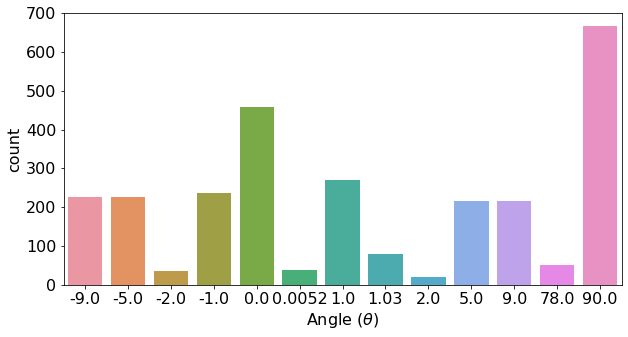

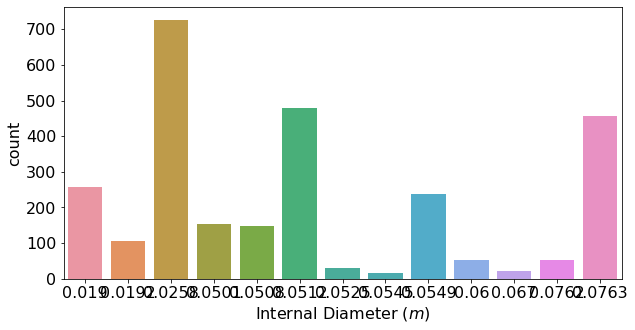

In [5]:
"""
Checking the unbalancedness on the inputs

Note: one of the features, "Ang" (i.e., the inclination
of the pipe in degrees), has the peculiarity of inducing
a slightly unbalanced dataset, as shown in the first plot below.
The same for the internal diameter.

Something similar may be verified for the other variables,
if wished
"""

# plot how many samples there exist for each value of the Ang variable
plt.figure()
sns.countplot(x = 'Ang', data = data)
plt.xlabel(r'Angle ($\theta$)')

# plot how many samples there exist for each value of the internal diameter variable
plt.figure()
sns.countplot(x = 'ID', data = data)
plt.xlabel(r'Internal Diameter ($m$)')

Text(0, 0.5, 'Number of data points')

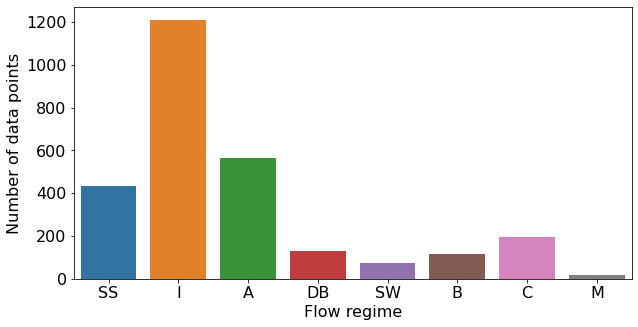

In [6]:
"""
Checking the unbalancedness on the outputs

The dataset is such that some classes are much
more represented than the other ones. This is an issue,
as said in the course. For a nice recap of what problems
one may encounter in this situation, see

https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
"""

plt.figure()
sns.countplot(x = 'Class_name', data = data)
plt.xlabel("Flow regime")
plt.ylabel("Number of data points")

## Task 12.2

Comment what you expect this unbalancedness will cause when, later on, we will use some pre-made algorithms for classifying test data from this dataset.

When using an unbalanced dataset, the classifier may be more prone to choose the heavy represented classes, like I here, merely due to the number of representations in this dataset. This will lead to a high accuracy score even for a bad model. In addition, classes such as M will most likely "never" be chosen for the same reasons. This will obviously depend on the choice of classifier, cost function and scoring strategy.

## Task 12.3

Load the part of data from the 'Petroleum to phase dataset' relative to the theoretical values about how oil may flow within pipes, depending on several geometrical and environmental values. This data corresponds to some boundaries on the inputs space that define opportune regions where the flows should nominally be of certain types. These boundaries will be then compared later on against the field measurements that we loaded above.

In [7]:
# load the theoretical data relative to horizontally placed pipes
h_annular    = pd.read_csv('./Petroleum2PhaseData/DecisionBoundaries/horizontal/annular.txt',    sep='\t').values
h_bf         = pd.read_csv('./Petroleum2PhaseData/DecisionBoundaries/horizontal/bf.txt',         sep='\t').values
h_db         = pd.read_csv('./Petroleum2PhaseData/DecisionBoundaries/horizontal/db.txt',         sep='\t').values
h_stratified = pd.read_csv('./Petroleum2PhaseData/DecisionBoundaries/horizontal/stratified.txt', sep='\t').values
h_wavy       = pd.read_csv('./Petroleum2PhaseData/DecisionBoundaries/horizontal/wavy.txt',       sep='\t').values

# load the theoretical data relative to vertically placed pipes
v_annular    = pd.read_csv('./Petroleum2PhaseData/DecisionBoundaries/vertical/annular.txt',      sep='\t').values
v_bf         = pd.read_csv('./Petroleum2PhaseData/DecisionBoundaries/vertical/bf.txt',           sep='\t').values
v_db         = pd.read_csv('./Petroleum2PhaseData/DecisionBoundaries/vertical/db.txt',           sep='\t').values

In [8]:
# to compare the measured data against the theoretical
# boundaries, select only the measurements relative to vertically placed pipes
vertical = data['Ang'] > 89
v_data   = data[vertical]

# actually through selecting only a subset of measurements
# we do not get anymore all the classes represented
print(v_data['Class_name'].unique())

# for readability -- assign the various samples to individual variables
I  = v_data.loc[v_data['Class_name']=='I']
A  = v_data.loc[v_data['Class_name']=='A']
B  = v_data.loc[v_data['Class_name']=='B']
C  = v_data.loc[v_data['Class_name']=='C']
M  = v_data.loc[v_data['Class_name']=='M']

['I' 'A' 'B' 'C' 'M']


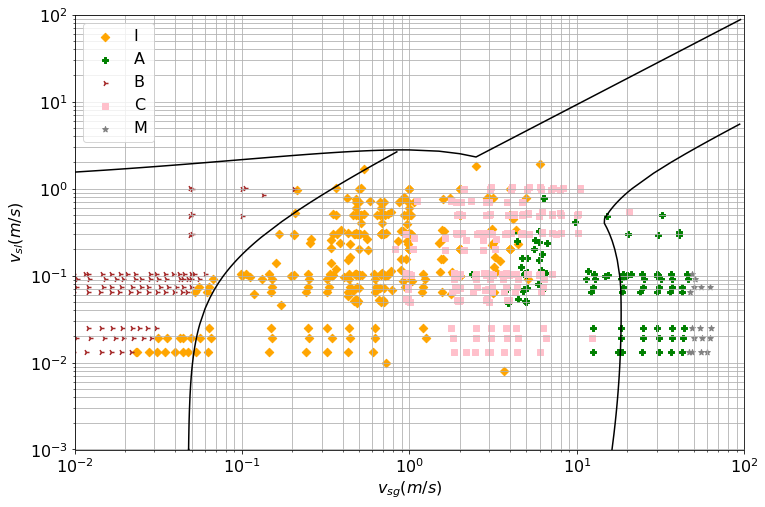

In [9]:
# initialize the plot
f = plt.figure(figsize = (12, 8))

# draw the theoretical boundaries with some black lines 
plt.plot(v_annular[:,0], v_annular[:,1], color='black')
plt.plot(v_bf[:,0],      v_bf[:,1],      color='black')
plt.plot(v_db[:,0],      v_db[:,1],      color='black')

# draw what has been measured in the field
i  = plt.scatter(I ['Vsg'], I ['Vsl'], marker='D', color='orange')
a  = plt.scatter(A ['Vsg'], A ['Vsl'], marker='P', color='green' )
b  = plt.scatter(B ['Vsg'], B ['Vsl'], marker='4', color='brown' )
c  = plt.scatter(C ['Vsg'], C ['Vsl'], marker='s', color='pink'  )
m  = plt.scatter(M ['Vsg'], M ['Vsl'], marker='*', color='grey'  )

# ancillary settings
plt.xscale('log')
plt.yscale('log')
plt.axis  ([0.01, 100, 0.01, 100])
plt.xticks([0.01, 0.1, 1, 10, 100])
plt.yticks([0.001, 0.01, 0.1, 1, 10, 100])
plt.grid  (True, which="both")
plt.legend( ( i,   a,   b,   c,   m), \
            ('I', 'A', 'B', 'C', 'M'))
plt.xlabel(r'$v_{sg}(m/s)$')
plt.ylabel(r'$v_{sl}(m/s)$')

# visualize the figure
plt.show()

## Task 12.4

Comment the results visualized by the figure above, focusing on:
- comparing the theoretical vs. the measured data,
- using this comparison to motivate whether one should try to see whether instead of the theoretical boundaries one should use a data driven approach.

(Note that something similar would happen if you were plotting measured vs. theoretical for horizontally placed pipes.)

We see a clear difference between the theoretical and measured values for these classes. The theoretical values are able to group class B and M well, and only one outlier of class C. For the classes I and A, on the other hand, the theoretical boundaries are not able to separate the data well. For these two classes we see a high variance in the dataset, compared to the others. There seems to be some physical factors not included in the modelling, which may come from either simplification or lack of understanding. This motivates the use for data driven approaches when classifying these models.

For this case, we see that the physical approach is able to classify to some degree, which means that a hybrid approach may be the way to go.

## Task 12.5

Run the code below, that loads the dataset in a way that is convenient for applying the classification algorithms in the sklearn package. 

In [10]:
# for readability, give the classical names to the variables
Y = data['Class_id'].values
X = data[['Vsl', 'Vsg', 'Ang', 'Density_L', 'Density_G', 'Visc_L', 'Visc_G', 'ST']].values

# scale also the X data, so to avoid scaling issues. See also
# https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
scaler = StandardScaler()
X = scaler.fit_transform(X)

# divide also the dataset in training and test sets
X_train, \
X_test,  \
y_train, \
y_test   = train_test_split(X, Y, test_size=0.2, random_state=1)

# DEBUG
print("training set size = {}\ntest set size     = {}".format(X_train.size, X_test.size))

training set size = 17536
test set size     = 4392


In [11]:
"""
Ancillary function that plots a confusion matrix in a nice way.
Normalization can be applied by setting `normalize=True`
"""

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm,       # the actual matrix
                          classes,
                          normalize = False,
                          title     = 'Confusion matrix',
                          cmap      = plt.cm.Blues ):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

## Task 12.6 - Logistic Regression

Complete the code below, that implements a logistic regression algorithm.

In [35]:
# load the right package
from sklearn.linear_model import LogisticRegression

# allocate the object that will perform the regression
lr = LogisticRegression( solver      = 'sag',
                         multi_class = 'auto',
                         max_iter    = 10000,
                         C           = 100000,
                         penalty     = 'l2')

# do the actual learning
lr.fit(X_train, y_train)

LogisticRegression(C=100000, max_iter=10000, solver='sag')

accuracy of logistic regression
 - on the training set: 0.8681569343065694
 - on the test set:     0.8415300546448088


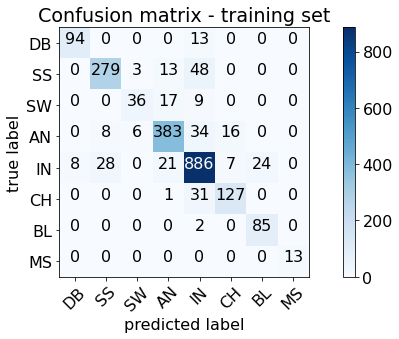

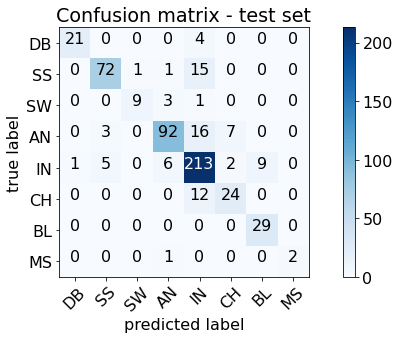

In [36]:
# compute the performance indexes on the training and test sets
y_lr_predict_train = lr.predict(X_train)
y_lr_predict_test  = lr.predict(X_test)
#
accuracy_LR_train = accuracy_score(y_train, y_lr_predict_train)
accuracy_LR_test  = accuracy_score(y_test,  y_lr_predict_test)

# DEBUG
print("accuracy of logistic regression\n - on the training set: {}\n - on the test set:     {}".format(accuracy_LR_train, accuracy_LR_test))

# compute the confusion matrices on the training and test sets
cm_train = confusion_matrix(y_train, y_lr_predict_train)
cm_test  = confusion_matrix(y_test,  y_lr_predict_test)

# for readability
classes = ['DB', 'SS', 'SW', 'AN', 'IN', 'CH', 'BL', 'MS']

# plot the confusion matrices
plot_confusion_matrix(cm_train,
                      classes,
                      normalize = False, # try both "True" and "False"!
                      title     ='Confusion matrix - training set')
#
plot_confusion_matrix(cm_test,
                      classes,
                      normalize = False, # try both "True" and "False"!
                      title     ='Confusion matrix - test set')

## Task 12.7

Comment the performance indexes and confusion matrices above, and state whether you think there may be overfitting / underfitting phenomena.

The difference in accuracy between the training- and test-data is not large, which is an indication that there is little overfitting in the system. However, we see from the confusion matrices that there is an overweight of IN variables contributing to the accuracy score. Therefore, good performance in classifying IN will lead to good overall performance, as discussed earlier.

There may be some underfitting, as a result of low accuracy.

## Task 12.8 - Random Forests

Complete the code below, that implements a random forest classification algorithm.

In [37]:
# import the necessary packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# allocate the object that will perform the classification
rfc = RandomForestClassifier()

# setup the parameters for the grid-search
grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion':    ['gini', 'entropy'],
    'bootstrap':    [True, False]
}

# construct an object that will take care of training
# the classifier while exhaustively searching for the
# best parameters values in a grid search fashion
gd_rfc = GridSearchCV(estimator = rfc,
                      param_grid = grid_param,
                      scoring   = 'accuracy',
                      cv        = 5,
                      n_jobs    = -1)

# launch the actual training & grid search
gd_rfc.fit(X_train, y_train)

# DEBUG
print("Best parameters found by GridSearchCV:")
print(gd_rfc.best_params_)
print("Best performance index found by GridSearchCV:")
print(gd_rfc.best_score_)

Best parameters found by GridSearchCV:
{'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 1000}
Best performance index found by GridSearchCV:
0.9174327290125962


accuracy of random forests:
 - on the training set: 0.9781021897810219
 - on the test set:     0.8797814207650273


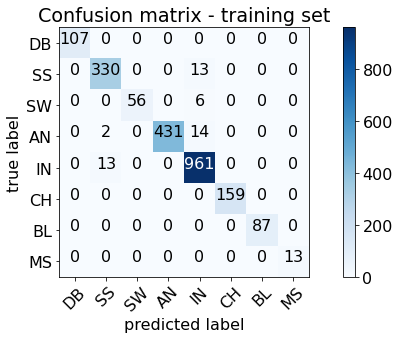

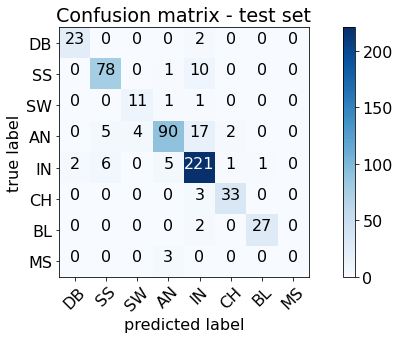

In [38]:
# compute the performance indexes on the training and test sets
y_rfc_predict_train = gd_rfc.predict(X_train)
y_rfc_predict_test  = gd_rfc.predict(X_test)
#
accuracy_RFC_train = accuracy_score(y_train, y_rfc_predict_train)
accuracy_RFC_test  = accuracy_score(y_test,  y_rfc_predict_test)

# DEBUG
print("accuracy of random forests:\n - on the training set: {}\n - on the test set:     {}".format(accuracy_RFC_train, accuracy_RFC_test))

# compute the confusion matrices on the training and test sets
cm_train = confusion_matrix(y_train, y_rfc_predict_train)
cm_test  = confusion_matrix(y_test,  y_rfc_predict_test)

# for readability
classes = ['DB', 'SS', 'SW', 'AN', 'IN', 'CH', 'BL', 'MS']

# plot the confusion matrices
plot_confusion_matrix(cm_train,
                      classes,
                      normalize = False, # try both "True" and "False"!
                      title     ='Confusion matrix - training set')
#
plot_confusion_matrix(cm_test,
                      classes,
                      normalize = False, # try both "True" and "False"!
                      title     ='Confusion matrix - test set')

## Task 12.9

As in Task 12.7, comment the performance indexes and confusion matrices above, and state whether you think there may be overfitting / underfitting phenomena. Compare moreover the various performance of the random forest again the logistic regressor, and draw your conclusions.

Here, the accuracy seems to point towards overfitting. We see from the confusion matrix of the test-set that the model created automatically classifies most of the points as IN, as described above.

Even though the Random forrest algorithm has a better accuracy, I would prefer the Logistic regression, due to overfitting. In my experience, data collected from the same dataset, tend to be similar, meaning that an overfitted model may yield a "good" performance on the data. If, however, we would use these models for a different dataset, with different distribution and variation, I believe that the LR model would perform better.



## Task 12.10 - SVC

Complete the code below, that implements a support vector classification algorithm.

In [76]:
# import the relative package
from sklearn.svm import SVC

# allocate the object that will eventually learn the classification rule
svc = SVC(C            = 100000,
          kernel       = 'rbf',
          degree       = 5,
          gamma        = 'scale', 
          coef0        = 0,
          shrinking    = True,
          probability  = False, 
          tol          = 1e-4,
          cache_size   = 200,
          class_weight = 'balanced', 
          verbose      = False,
          max_iter     = -1,
          decision_function_shape = 'ovo')

# do the actual training
svc.fit(X_train, y_train)

SVC(C=100000, class_weight='balanced', coef0=0, decision_function_shape='ovo',
    degree=5, tol=0.0001)

accuracy of SVCs:
 - on the training set: 0.9238138686131386
 - on the test set:     0.8761384335154827


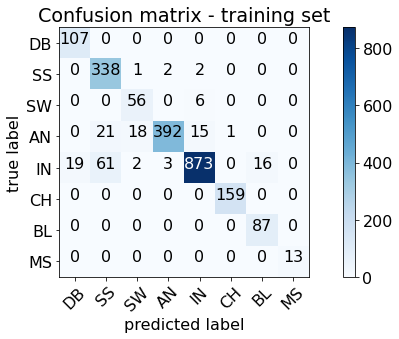

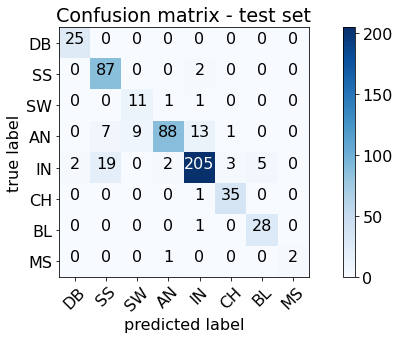

In [77]:
# compute the performance indexes on the training and test sets
y_svc_predict_train = svc.predict(X_train)
y_svc_predict_test  = svc.predict(X_test)
#
accuracy_SVC_train = accuracy_score(y_train, y_svc_predict_train)
accuracy_SVC_test  = accuracy_score(y_test,  y_svc_predict_test)

# DEBUG
print("accuracy of SVCs:\n - on the training set: {}\n - on the test set:     {}".format(accuracy_SVC_train, accuracy_SVC_test))

# compute the confusion matrices on the training and test sets
cm_train = confusion_matrix(y_train, y_svc_predict_train)
cm_test  = confusion_matrix(y_test,  y_svc_predict_test)

# for readability
classes = ['DB', 'SS', 'SW', 'AN', 'IN', 'CH', 'BL', 'MS']

# plot the confusion matrices
plot_confusion_matrix(cm_train,
                      classes,
                      normalize = False, # try both "True" and "False"!
                      title     ='Confusion matrix - training set')
#
plot_confusion_matrix(cm_test,
                      classes,
                      normalize = False, # try both "True" and "False"!
                      title     ='Confusion matrix - test set')

## Task 12.11

As in Task 12.7 and 12.9, comment the performance indexes and confusion matrices above, and state whether you think there may be overfitting / underfitting phenomena. Compare moreover the various performance of the SVC against the random forest and logistic regressor ones, and draw your conclusions.

In difference to the other methods, SVC yields a more evenly distributed result. In other words, the accuracy is more even for the different classes. This is mainly because of the parameter "class_weight" which takes the unbalancednes of the dataset into account. This yields a model less affected by the unbalancedness of the dataset. Moer concrete, this means that the classifier does not choose "IN" as default.

This model is less fitted to the distribution of the dataset. I would therefore say that this model is the best!